# KimmelNet

Welcome to KimmelNet! If you have set up your python environment correctly, by following [the instructions on GitHub](https://github.com/djpbarry/KimmelNET/tree/main#run-kimmelnet-on-your-own-data), then clicking the _Run All_ button above should result in all the code below being successfully executed - you should see plenty of graphical output (and no errors!). But let's go through each cell one by one.

This first cell just gets everything set up - unless you are familiar with the inner workings of TensorFlow, you probably don't want to change anything here!

Note that the expected size of the input images is 268 x 224 pixels (width x height). Don't worry if your images are a different size - they will be scaled automatically. However, if the aspect ratio of your images is substantially different to this, then KimmelNet may not perform terribly well.

In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from keras.layers import TFSMLayer

def func(x, a):
    return a * x


# Variables pertaining to trained model

image_size = (224, 268)
cropped_image_size = (224, 224)
batch_size = 32
buffer_size = 4

These next variables are two that you _may_ wish to change. By default, they point to the location of the sample test data and pretrained KimmelNet model. However, if your test data is  located elsewhere, or you want to use a version of KimmelNet you have updated yourself (by way of transfer learning or otherwise), you will need to specify the relevant paths here:

In [18]:
test_path = './test_data'
model_path = './KimmelNet_Model/published_model_multi_gpu_custom_augmentation_trained_model'

That's it! You don't need to do anything else.

If you run this next cell, all your test data will be parsed and loaded into a dataset - you should see the total number of images in the dataset displayed.

In [19]:
# parse_image function returns an image and the image's label (which is given by the name of the folder in which
# the image is saved) given a filename
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = float(parts[-2])
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, image_size)
    return image, label


# Construct a tensorflow Dataset based on the file list in the test_path parent directory
test_list_ds = tf.data.Dataset.list_files(str(test_path + os.sep + "*" + os.sep + "*.png")).shuffle(1000)
test_ds = test_list_ds.map(parse_image).batch(batch_size)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE).cache()

print("Number of images in test dataset: ", test_list_ds.cardinality().numpy())

Number of images in test dataset:  46


In this next cell, the KimmelNet model is loaded and a summary of the model is displayed:

In [20]:
# Load model using TFSMLayer
model = tf.keras.Sequential([
    TFSMLayer(model_path, call_endpoint='serving_default')
])
model.compile()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfsm_layer_1 (TFSMLayer)        │ ?                      │       821,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,121 (3.13 MB)

 Trainable params: 821,121 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

Next, we display a sample selection of the test dataset, to ensure everything is behaving as it should be:

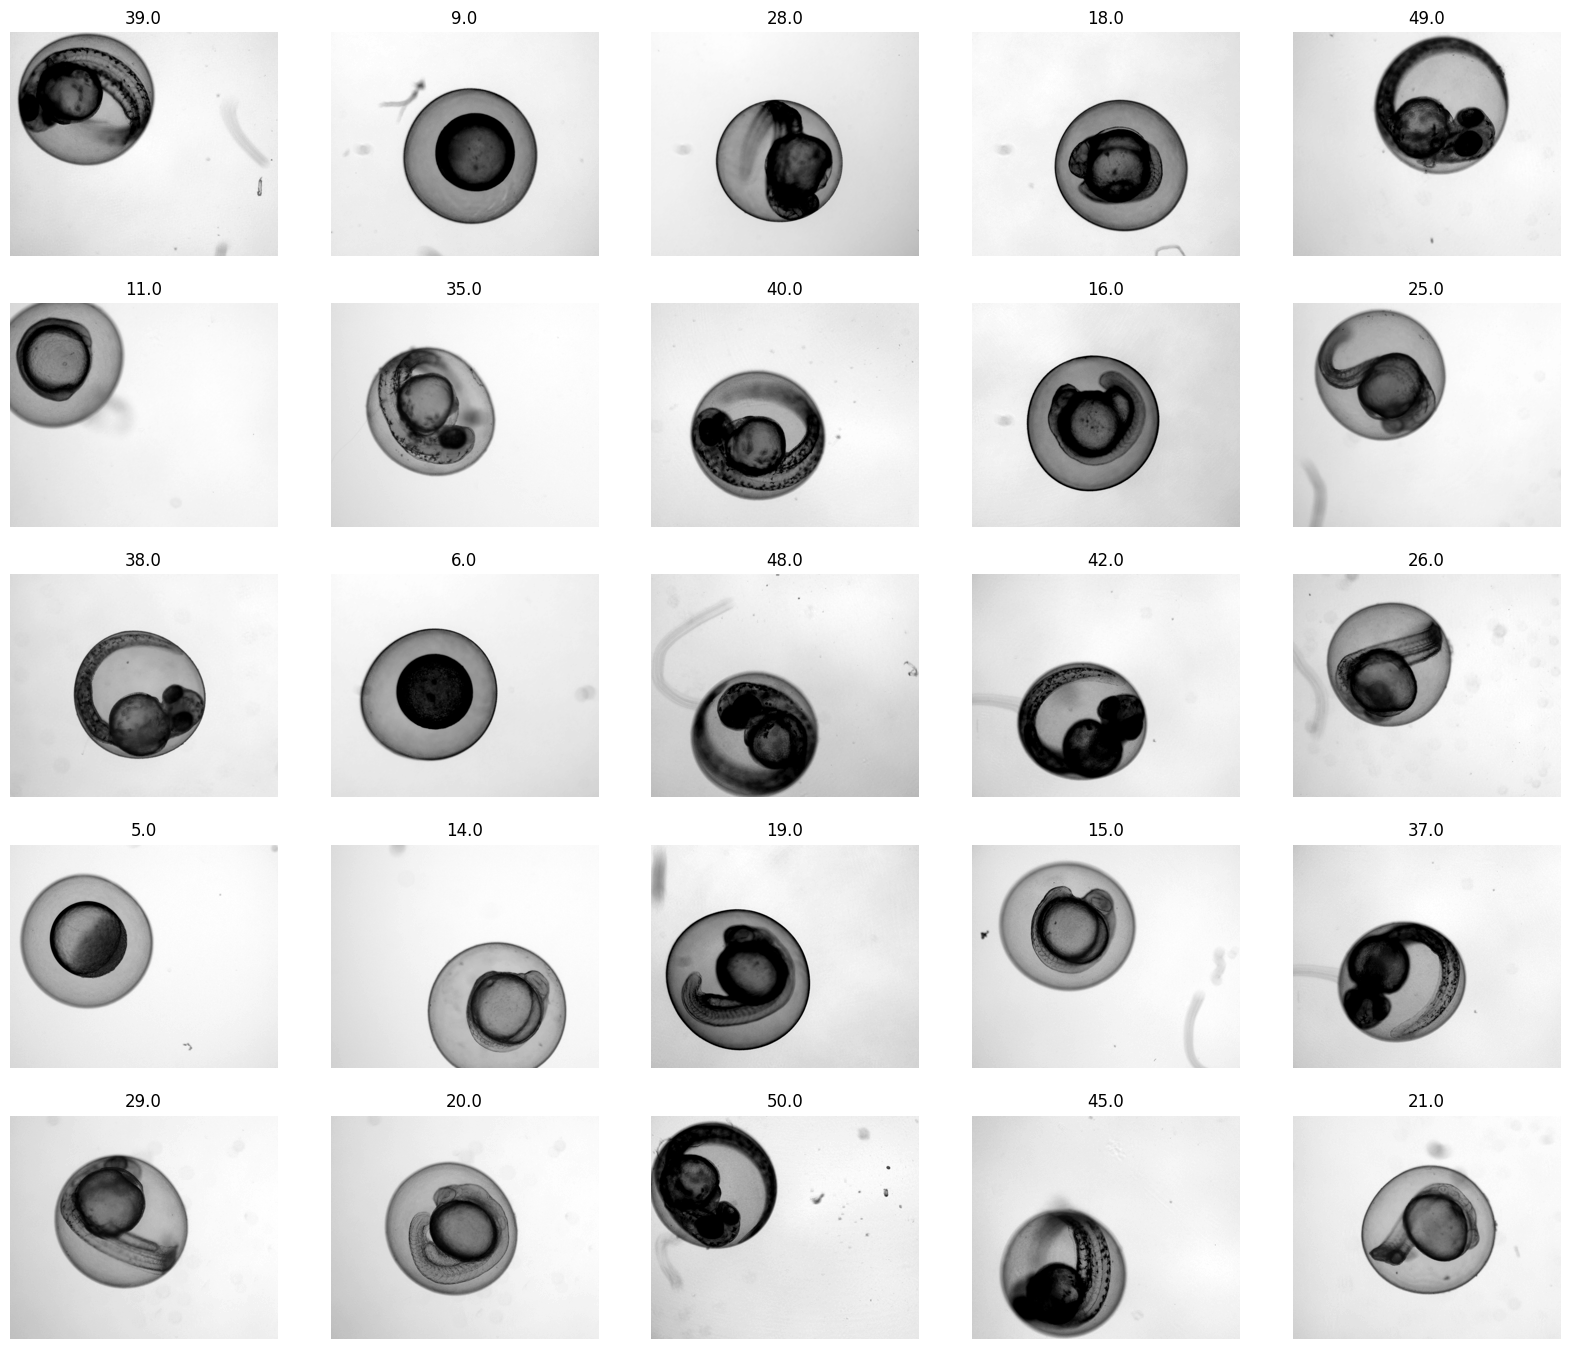

In [21]:
# Display a sample of the test data

%matplotlib inline

plt.figure(num=3, figsize=(20, 17))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(labels[i].numpy())
        plt.axis("off")
plt.show()

Now we get on to running KimmelNet on the test data. Here, you should see a "Test Loss" displayed for the entire test dataset. This value tells you how (in)accurate KimmelNet has been at predicting the true hours post-fertilisation for all the images in your test data. Note that this value has units of hours<sup>2</sup>, so take the square root to get the mean error in hours. Consult the manuscript describing KimmelNet to get an idea of what kind of error values you can expect.

In [22]:
predictions = model.predict(test_ds)

# Use the correct key based on Step 1
output_key = list(predictions.keys())[0]  # Get the first key
pred_values = predictions[output_key]  # Extract the actual predictions

# Print first 10 predictions
for i, pred in enumerate(pred_values[:10]):
    print(f"Image {i}: Predicted value = {pred[0]:.2f}")


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020D1C81F640> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
Image 0: Predicted value = 44.93
Image 1: Predicted value = 34.38
Image 2: Predicted value = 6.67
Image 3: Predicted value = 32.81
Image 4: Predicted value = 48.84
Image 5: Predicted value = 39.60

Now we plot the predictions for each individual image against the true hpf for that image and fit a line to the resulting point cloud.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


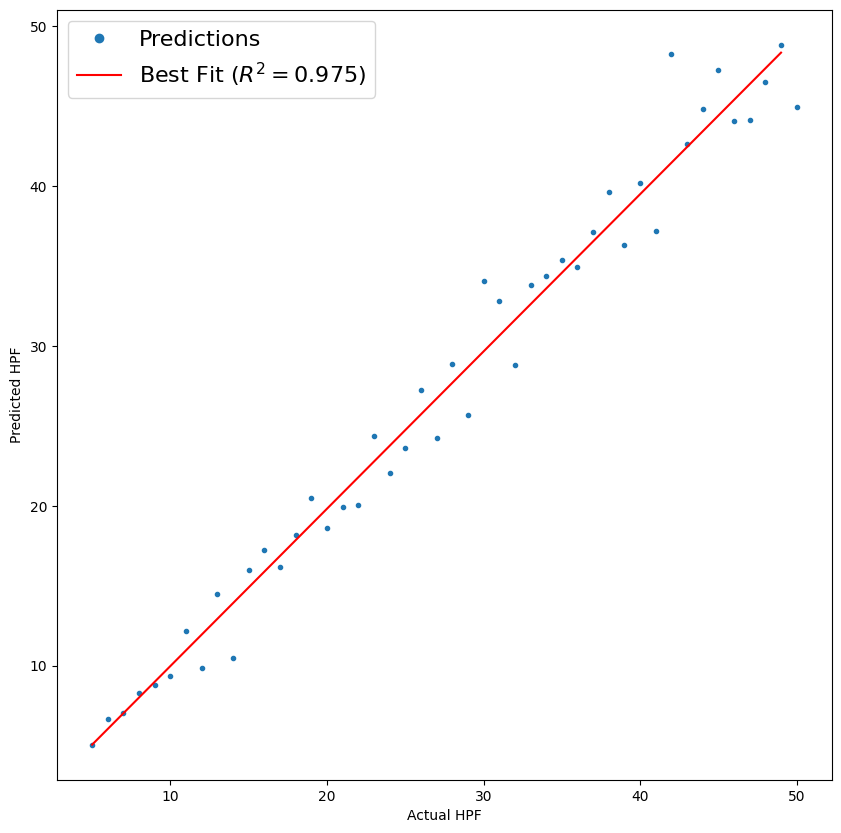

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Initialize empty arrays for labels and predictions
labels = np.array([])
predictions = np.array([])

# Extract the correct output key from the model
output_key = list(model.predict(next(iter(test_ds))[0]).keys())[0]  # Get first key

# Loop through dataset and collect predictions
for x, y in test_ds:
    p_dict = model.predict(x, verbose=1)  # Get dictionary of predictions
    p = p_dict[output_key]  # Extract relevant output

    # Flatten predictions and labels to ensure 1D arrays
    predictions = np.concatenate([predictions, p.flatten()])
    labels = np.concatenate([labels, y.numpy().flatten()])

# Fit a linear model
linear_model = np.polyfit(labels, predictions, 1)
linear_model_fn = np.poly1d(linear_model)

# Fit non-linear model
popt, pcov = curve_fit(func, labels, predictions)
r2 = r2_score(predictions, func(labels, *popt))

# Generate range for best-fit line
x_s = np.arange(min(labels), max(labels), 1)

# Plot results
plt.figure(figsize=(10, 10))
plt.plot(labels, predictions, 'o', markersize=3, label='Predictions')
plt.plot(x_s, linear_model_fn(x_s), color="red", label=f"Best Fit ($R^2 = {r2:.3f}$)")
plt.xlabel("Actual HPF")
plt.ylabel("Predicted HPF")
plt.legend(fontsize=16, markerscale=2.0)
plt.show()


Finally, we produce a plot of the distribution of prediction errors:

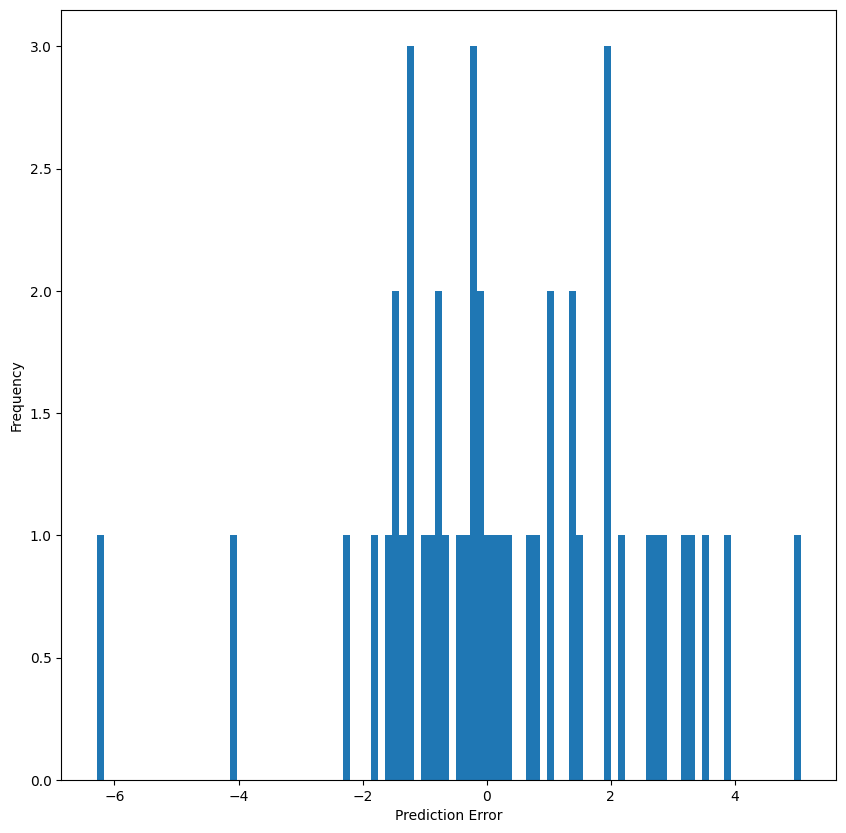

In [24]:
# Plot the distribution of errors (the differences between predictions and true la)

errs = labels - predictions

plt.figure(num=4, figsize=(10, 10))
plt.hist(errs, bins=100)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()